In [1]:
import sys
sys.path.append('C:/Users/mechadmin/Documents/GitHub/pyiga/nurbs_models')
from model_structure import NURBSGenerator
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from pyiga.geometry import *
from pyiga import approx, bspline

In [2]:
degree = 3
num_ctrlpts = 10
knotvector = np.concatenate(([0] * (degree + 1), np.linspace(0, 1, num_ctrlpts - degree), [1] * (degree + 1)))


In [3]:
print(knotvector)

[0.         0.         0.         0.         0.         0.16666667
 0.33333333 0.5        0.66666667 0.83333333 1.         1.
 1.         1.         1.        ]


53
4 159 3 53
Model loaded successfully.
(53,)


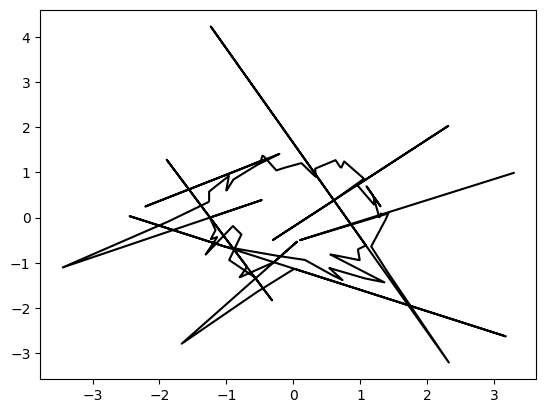

In [4]:

degree = 3
n_kv = 52
# knotvector = np.concatenate(([0] * (degree + 1), np.linspace(0, 1, num_ctrlpts - degree), [1] * (degree + 1)))
knotvector = bspline.make_knots(1, 0.0, 1.0, n_kv)
num_ctrlpts = knotvector.numdofs
print(num_ctrlpts)
input_dim = 4  # Superformula parameters
output_dim = num_ctrlpts * 2 + num_ctrlpts  # Control points and weights
print(input_dim, output_dim, degree, num_ctrlpts)
# Initialize the model structure
model = NURBSGenerator(input_dim, output_dim, degree, num_ctrlpts)

# Load the saved model weights
model.load_state_dict(torch.load('C:\\Users\\mechadmin\\Documents\\GitHub\\pyiga\\nurbs_generator_50.pth'))
model.eval()  # Set the model to evaluation mode
print("Model loaded successfully.")

# Use the model to generate NURBS control points and weights from new superformula parameters
new_params = torch.tensor([0.5, 18, 4, 0.3], dtype=torch.float32)
output = model(new_params)
ctrlpts, weights = output.split([num_ctrlpts*2, num_ctrlpts])
ctrlpts = ctrlpts.view(num_ctrlpts, 2)
weights = weights.view(num_ctrlpts)



# Calculate NURBS points using custom function
# nurbs_points = calculate_nurbs_points(ctrlpts, weights, knotvector, degree)
from pyiga.geometry import *
from pyiga import approx, bspline
from pyiga import bspline, assemble, vform, geometry, vis, solvers
ctrlpts_np = ctrlpts.detach().numpy()
weights_np = weights.detach().numpy()

nurbs = NurbsFunc((knotvector,), ctrlpts_np.copy(), weights=weights_np)
vis.plot_geo(nurbs,res=500, linewidth=None, color='black')
# plt.axis('equal');


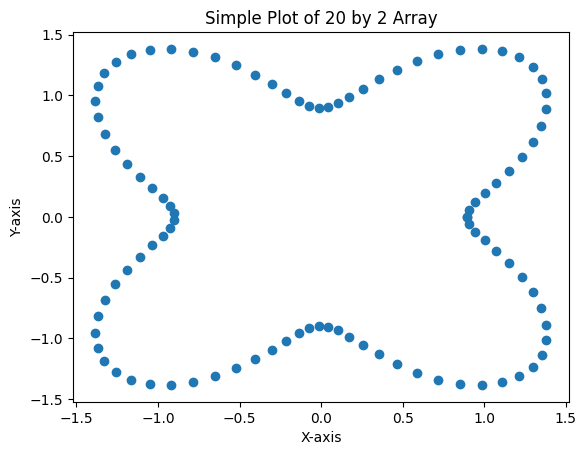

In [5]:
def cal_c(r, a, L0):
    return np.sqrt(2)*np.sqrt(np.pi*(3+3*r**2+2*r)*a*L0)/(np.pi*(3+3*r**2+2*r))
def superformula(r, L0, n, a=0.5, d=1, num_res=100):
    theta = np.linspace(0, 2 * np.pi, num_res)
    c = cal_c(r,a,L0)
    result = c*((1+r)-d*(-1)**((n+2)/2)*(r-1)*np.cos(n*theta))
    x = result * np.cos(theta)
    y = result * np.sin(theta)
    return np.vstack((x, y)).T
res = superformula(0.5, 20, 4, 0.3)
# Plot the data
plt.plot(res[:, 0], res[:, 1], 'o')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Simple Plot of 20 by 2 Array')
plt.show()


In [6]:
print(weights)

tensor([-35.1783, -30.8767, -12.0453,  23.3412,  25.4249,   4.0088, -12.0077,
        -48.2574, -30.1219, -10.1995, -25.8420, -13.8692,  -5.4734, -23.5346,
        -24.2494, -16.3129,  -7.4126, -20.1053, -29.1033,   3.5566,  19.0073,
          8.4806,  13.3614,  46.4107,  14.2721,   0.8668, -21.0554, -43.6952,
        -35.2412, -43.1139, -36.2816,  -2.0769, -49.3687,  -4.5572,   2.5704,
         11.3983,  36.7568,  -1.1054, -15.5086,   3.6873,  69.2682,   7.1094,
         17.4737,   1.5949,   5.7537,  16.4249,  14.9753,   7.9432,  -1.2373,
        -47.7312, -18.6028,  -6.8276, -10.2831], grad_fn=<ViewBackward0>)


In [7]:
print(len(ctrlpts_np[0]))

2


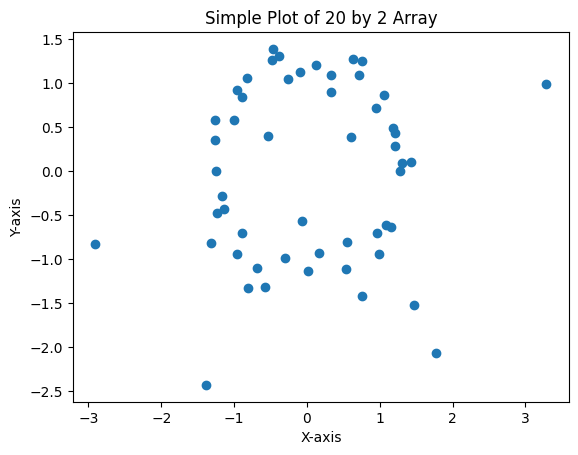

In [8]:

# Plot the data
plt.plot(ctrlpts_np[:, 0], ctrlpts_np[:, 1], 'o')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Simple Plot of 20 by 2 Array')
plt.show()


In [9]:
def basis_function(i, k, u, knot_vector):
    if k == 0:
        return 1.0 if knot_vector[i] <= u < knot_vector[i + 1] else 0.0
    else:
        denom1 = knot_vector[i + k] - knot_vector[i]
        denom2 = knot_vector[i + k + 1] - knot_vector[i + 1]
        term1 = ((u - knot_vector[i]) / denom1) * basis_function(i, k - 1, u, knot_vector) if denom1 != 0 else 0
        term2 = ((knot_vector[i + k + 1] - u) / denom2) * basis_function(i + 1, k - 1, u, knot_vector) if denom2 != 0 else 0
        return term1 + term2

def calculate_nurbs_points(ctrlpts, weights, knotvector, degree, num_points=100, epsilon=1e-6):
    u_values = np.linspace(knotvector[degree], knotvector[-degree-1], num_points)
    nurbs_points = []
    for u in u_values:
        numerator = torch.zeros(2, dtype=ctrlpts.dtype, device=ctrlpts.device)
        denominator = torch.tensor(0.0, dtype=ctrlpts.dtype, device=ctrlpts.device)
        for i in range(len(ctrlpts)):
            b = basis_function(i, degree, u, knotvector)
            numerator += b * weights[i] * ctrlpts[i]
            denominator += b * weights[i]
        nurbs_points.append(numerator / (denominator + epsilon))
    return torch.stack(nurbs_points)

In [10]:
print(knotvector.kv)

[0.         0.         0.01923077 0.03846154 0.05769231 0.07692308
 0.09615385 0.11538462 0.13461538 0.15384615 0.17307692 0.19230769
 0.21153846 0.23076923 0.25       0.26923077 0.28846154 0.30769231
 0.32692308 0.34615385 0.36538462 0.38461538 0.40384615 0.42307692
 0.44230769 0.46153846 0.48076923 0.5        0.51923077 0.53846154
 0.55769231 0.57692308 0.59615385 0.61538462 0.63461538 0.65384615
 0.67307692 0.69230769 0.71153846 0.73076923 0.75       0.76923077
 0.78846154 0.80769231 0.82692308 0.84615385 0.86538462 0.88461538
 0.90384615 0.92307692 0.94230769 0.96153846 0.98076923 1.
 1.        ]


In [11]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from pyiga import approx, bspline
knotvector = knotvector.kv
knotvector = np.append(knotvector,[1.0,1.0])
nurbs_points = calculate_nurbs_points(ctrlpts, weights, knotvector, degree)
criterion = nn.MSELoss()
# Calculate loss
superformula_pts = res


In [12]:
import numpy as np

# Example data sets
actual = superformula_pts[:nurbs_points.shape[0]]
predicted = nurbs_points.detach().numpy()

# Compute Mean Squared Error
mse = np.mean((actual - predicted) ** 2)

print(f"MSE: {mse}")


MSE: 0.057560432696146524


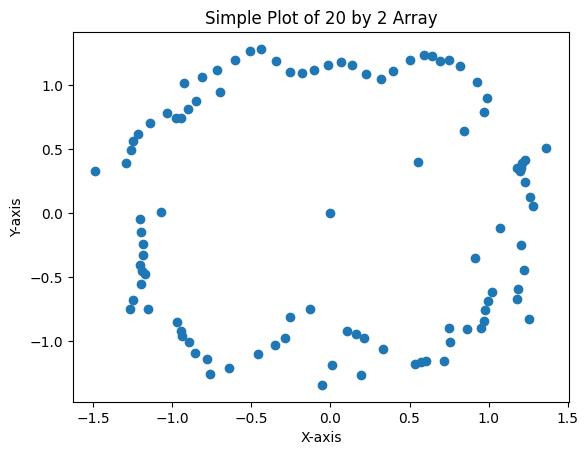

In [13]:
predicted.shape
# Plot the data
plt.plot(predicted[:, 0], predicted[:, 1], 'o')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Simple Plot of 20 by 2 Array')
plt.show()